<h1>Dependencies

In [ ]:
!pip install stable-baselines3[extra]

In [ ]:
!pip install gym

In [ ]:
!pip show gym

In [1]:
import sys
sys.path.append('c:\\users\\hp\\desktop\\projectpeptide\\summer_internship_2023\\projectpeptide\\lib\\site-packages')

In [6]:
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import numpy as np
import pandas as pd
import random

import os
import copy
import statistics

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv

from sklearn.metrics.pairwise import cosine_similarity
from rdkit import Chem
from rdkit.Chem import Crippen

2024-05-05 09:39:05.918279: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 09:39:09.825147: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 09:39:15.566911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<h1> Types of Spaces

In [2]:
Discrete(3).sample()

1

In [3]:
Box(0,1,shape=(3,3)).sample()

array([[0.5822426 , 0.73995286, 0.0273481 ],
       [0.8896991 , 0.86799115, 0.7636945 ],
       [0.3177717 , 0.7121066 , 0.4306491 ]], dtype=float32)

In [4]:
Tuple((Discrete(2), Box(0,100, shape=(1,)))).sample()

(0, array([7.2209864], dtype=float32))

In [5]:
Dict({'height':Discrete(2), "speed":Box(0,100, shape=(1,))}).sample()

OrderedDict([('height', 0), ('speed', array([23.1337], dtype=float32))])

In [6]:
MultiBinary(4).sample()

array([0, 1, 0, 0], dtype=int8)

In [7]:
MultiDiscrete([5,2,2]).sample()

array([1, 0, 0])

In [23]:
MultiDiscrete([20] * 5).sample()

array([ 4,  8,  9,  6, 14])

In [43]:
y = MultiDiscrete([20, 5]).sample()
print(y)
print(y[1])
print(y[0])

[5 0]
0
5


In [49]:
MultiDiscrete([20] * 5).sample()

array([10,  1, 10, 16,  7])

<h1> Building an Environment

In [7]:
len_peptide = 5

In [185]:
# # Define a dictionary mapping amino acid names to their one-letter abbreviations
# amino_acid_mapping = {
#     'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
#     'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
#     'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
#     'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
# }

In [8]:
# Function to convert amino acid indices to a peptide sequence
def indices_to_peptide(indices):
    # Define a dictionary mapping amino acid names to their one-letter abbreviations
    amino_acid_mapping = {
        'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
        'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
        'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
        'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
    }
    amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

    peptide_sequence_oneLetter = ''.join([amino_acid_mapping[amino_acids[i]] for i in indices])
    peptide_sequence_threeLetter = '-'.join([amino_acids[i] for i in indices])
    
    return peptide_sequence_oneLetter, peptide_sequence_threeLetter

def oneLetter_to_threeLetter(peptide):
    amino_acid_mapping = {
        'A': 'ALA', 'R': 'ARG', 'N': 'ASN', 'D': 'ASP', 'C': 'CYS',
        'Q': 'GLN', 'E': 'GLU', 'G': 'GLY', 'H': 'HIS', 'I': 'ILE',
        'L': 'LEU', 'K': 'LYS', 'M': 'MET', 'F': 'PHE', 'P': 'PRO',
        'S': 'SER', 'T': 'THR', 'W': 'TRP', 'Y': 'TYR', 'V': 'VAL'
    }

    # Convert the one-letter amino acid code to its corresponding three-letter code
    three_letter_peptide = '-'.join([amino_acid_mapping[aa] for aa in peptide])

    return three_letter_peptide


#function to convert peptide sequence to indices of amino acids
def peptide_to_indices(peptide):
    amino_acid_mapping = {
        'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
        'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
        'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
        'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
    }
    amino_acids = {'ALA': 0, 'ARG': 1, 'ASN': 2, 'ASP': 3, 'CYS': 4, \
                    'GLN': 5, 'GLU': 6, 'GLY': 7, 'HIS': 8, 'ILE': 9, 'LEU': 10,\
                    'LYS': 11, 'MET': 12, 'PHE': 13, 'PRO': 14, 'SER': 15, 'THR': 16, 'TRP': 17, 'TYR': 18, 'VAL': 19}
    
    # Split the peptide chain into individual amino acids
    amino_acids_list = peptide.split('-')
    
    # Convert each amino acid to its corresponding index
    indices_list = [amino_acids[aa] for aa in amino_acids_list]
    
    return indices_list

In [9]:
def maxValueIndex(my_list):
    # Get the maximum value from the list
    max_value = max(my_list)
    # Get all indices where the max value occurs using a list comprehension
    indices_max_value = [index for index, value in enumerate(my_list) if value == max_value]

    return max_value, indices_max_value


In [28]:
#Reward as logP only
def calculate_logP(peptide_sequence):
    # Create an RDKit molecule object
    mol = Chem.MolFromSequence(peptide_sequence)

    # Check if the molecule is valid
    if mol is not None:
        # Calculate the logP value using Crippen's method
        logP = Crippen.MolLogP(mol)
        return logP
    else:
        # Return a placeholder value (you may want to handle invalid sequences differently)
        return -1000000000.0

In [38]:
calculate_logP('AAAAA')
indices_to_peptide([1,1,1,1,1])[0]

'RRRRR'

In [3]:
ap_values = [2.47, 2.42, 2.54, 2.49, 2.38, 2.38, 2.27, 2.24, 2.28, 2.17, 2.23, 2.35, 2.15, 2.14, 2.50, 2.38, 2.20, 2.18, 2.28, 2.34, 2.14, 2.13, 2.16, 2.14, 2.13, 2.03, 2.09, 2.10, 2.16, 2.05, 2.08, 2.07, 1.94, 2.06, 2.11, 2.01, 2.38, 2.12, 2.02, 2.35, 2.00, 1.99, 2.11, 2.09, 2.01, 1.99, 2.04, 2.44, 1.99, 1.98, 1.98, 2.26, 2.02, 1.96, 1.94, 1.92, 2.46, 1.91, 1.99, 2.01, 1.91, 1.88, 2.28, 2.01, 2.49, 1.92, 2.28, 1.95, 1.96, 1.87, 2.01, 1.94, 1.85, 2.26, 1.93, 1.91, 1.96, 1.96, 2.37, 1.92, 1.88, 1.99, 1.88, 2.01, 1.81, 1.93, 2.23, 1.97, 1.91, 1.96, 1.94, 1.86, 2.24, 1.86, 1.88, 2.36, 1.91, 2.12, 1.83, 1.73]
len(ap_values)

100

In [55]:
def random_ap(random_pentapeptide): #peptide to be as a integer array.
    ap_values = [2.47, 2.42, 2.54, 2.49, 2.38, 2.38, 2.27, 2.24, 2.28, 2.17, 2.23, 2.35, 2.15, 2.14, 2.50, \
                2.38, 2.20, 2.18, 2.28, 2.34, 2.14, 2.13, 2.16, 2.14, 2.13, 2.03, 2.09, 2.10, 2.16, 2.05, \
                2.08, 2.07, 1.94, 2.06, 2.11, 2.01, 2.38, 2.12, 2.02, 2.35, 2.00, 1.99, 2.11, 2.09, 2.01, 1.99, \
                2.04, 2.44, 1.99, 1.98, 1.98, 2.26, 2.02, 1.96, 1.94, 1.92, 2.46, 1.91, 1.99, 2.01, 1.91, 1.88, 2.28,\
                2.01, 2.49, 1.92, 2.28, 1.95, 1.96, 1.87, 2.01, 1.94, 1.85, 2.26, 1.93, 1.91, 1.96, 1.96, 2.37, 1.92, \
                1.88, 1.99, 1.88, 2.01, 1.81, 1.93, 2.23, 1.97, 1.91, 1.96, 1.94, 1.86, 2.24, 1.86, 1.88, 2.36, 1.91, 2.12, 1.83, 1.73]


    std_ap_values = statistics.stdev(ap_values)
    mean_ap_values = statistics.mean(ap_values)
    
    pentapeptides = [
    "YPGVY", "SYCGY", "PTPCY", "PCPYC", "YHSQY", "TSPCY", "FKDFF", "FFEKF", "KWEFF", "FKDFI",\
    "FFKEF", "STPCY", "IKDFF", "FIKDF", "CPPHY", "VPPYA", "KWEFY", "FEKFF", "KWMDF", "PSPYV",\
    "FEFFK", "YDRFF", "KEFFW", "KDFYW", "FKWYD", "FKIDF", "FFDFK", "LKEFF", "CCPYA", "CDWYY",\
    "WDPYV", "KVPWY", "WVEYC", "WKPYV", "RWLDY", "KVPYF", "PPNYY", "WKDMF", "YKGYY", "PPQYY",\
    "YDCYW", "YMEYY", "WKPYY", "WKPYC", "FELKF", "VHPRY", "KCPFY", "PPPYT", "YSDFY", "VKPWY",\
    "YVPWK", "PGPYY", "HWMEY", "CDCWW", "IKPYY", "MYDYY", "PPPHY", "FVPDY", "CYPDF", "SWLDY",\
    "YMDYY", "DVPYY", "PPPCY", "KPHFY", "PPPYS", "CKPYY", "PSPSY", "PKFYY", "KPFFT", "FGYYK",\
    "FSPKF", "LKPYY", "FTDYM", "PSPNY", "MKPYY", "YKPYL", "FSPDY", "KWPYM", "PPPYA", "PFDHF",\
    "YMPKY", "PKPFY", "PKSYY", "PKPWY", "PKPYV", "PKPYF", "PPPSY", "PDPFF", "PKPYY", "PPGYY",\
    "FDPYP", "GFPDF", "PPPNY", "PPKYY", "FPPKF", "PPPYP", "DPPWY", "PPPGY", "PKPYM", "PFEPF"
    ]

    pentapeptides_indices = []
    for peptide in pentapeptides:
        pentapeptides_indices.append(peptide_to_indices(oneLetter_to_threeLetter(peptide)))
    
    similarity_array = [] #o find the most similar peptide from the data above, by checking the amino acid on a position.
    for i in pentapeptides_indices:
        difference = [x - y for x, y in zip(i, random_pentapeptide)] #checks whether the amino acid at a position is same as from the data given
        similarity = difference.count(0) #checks how many have no (i.e. 0) differences
        similarity_array.append(similarity)
    
    maxvalue, indicesCorr = maxValueIndex(similarity_array) #most similar and the index of that peptide
    # print(f'Similarity: {maxvalue}, Indexes: {indicesCorr}')
    if maxvalue == 0: #no similarity with any given pentapeptide
        random_ap = mean_ap_values + 20*std_ap_values
    elif maxvalue == 1:
        if len(indicesCorr) > 10:
            average = 0
            for i in indicesCorr:
                average += ap_values[i]
            random_ap = average/len(indicesCorr) 
        if len(indicesCorr) <= 10:
            random_ap =  mean_ap_values + 5*std_ap_values
    elif maxvalue == 2:
        if len(indicesCorr) >= 3:
            average = 0
            for i in indicesCorr:
                average += ap_values[i]
            random_ap = average/len(indicesCorr) 
        if len(indicesCorr) < 3:
            random_ap =  mean_ap_values + (5-len(indicesCorr))*std_ap_values
    elif maxvalue == 3:
        average = 0
        for i in indicesCorr:
            average += ap_values[i]
        random_ap = average/len(indicesCorr)
    elif maxvalue == 4:
        average = 0
        for i in indicesCorr:
            average += ap_values[i]
        random_ap = average/len(indicesCorr)
    elif maxvalue == 5:
        random_ap = ap_values[indicesCorr[0]]
    
    similar_chains = []
    for i in indicesCorr:
        similar_chains.append(pentapeptides_indices[i])

    return random_ap, maxvalue, similar_chains

In [15]:
peptide = MultiDiscrete([20] * len_peptide).sample()

# Convert indices to a tripeptide sequence
sequence = indices_to_peptide(peptide)
hydrophobicity = calculate_logP(sequence)

print('Protein chain as interger: {}\nProtein chain as string: {}\nHydrophobicity value for protein chain: {}'.format(peptide, sequence, hydrophobicity))

Protein chain as interger: [19  2  5  2  7]
Protein chain as string: VAL-ASN-GLN-ASN-GLY
Hydrophobicity value for protein chain: -9.13859999999997


In [63]:
class peptideEnv(Env):
    
    def __init__(self):
        
        # Actions taken are placing the randomized amino acid at the randomized position of the peptide 
        self.action_space = MultiDiscrete([20, len_peptide])
        # all the peptides sequence possible
        self.observation_space = MultiDiscrete([20] * len_peptide)
        # Set start as a randomized peptide
        self.state = MultiDiscrete([20] * len_peptide).sample()
        self.critical_logP = -1000000000.0

        #1 episode has 100 time-steps
        self.numAction = 100
        
    def step(self, action):
        
        # Extract amino acid and position from the action
        amino_acid = action[0]
        position = action[1]
        
        previous_peptide = copy.deepcopy(self.state)
        # Update the state based on the action
        self.state[position] = amino_acid
        self.numAction -=1
        
        # Convert indices to a peptide sequence and calculate logP- hydrophobicity 
        # for the peptide
        sequence = indices_to_peptide(self.state)[0]
        logP_value = calculate_logP(sequence)
        ap_value, similarity_value, similar_chains = random_ap(self.state)
        # print(ap_value)

        # Sparse reward, only rewarding when better logP calculated.
        if logP_value > self.critical_logP and ap_value > 2: 
            reward = 1 
            self.critical_logP = logP_value
        elif logP_value == self.critical_logP:
            reward = 0
        else:
            reward = -1 
        truncated = False
        # Check if episode is completed
        if self.numAction <= 0: 
            done = True
        else:
            done = False
            
        info = {"Peptide before step": previous_peptide, "Peptide after step" : self.state, \
                "LogP_value": logP_value, "AP_value": ap_value, "similarity_value": similarity_value, 'Similarity with:': similar_chains}
        globals()["chain"] = info
        return self.state, reward, done, truncated, info
 
    def render(self):
        pass
    
    def reset(self, seed = None):
        # Seed the random number generator if a seed is provided
        if seed is not None:
            np.random.seed(seed)
        # Reset the peptide to a new randomized state
        self.state = MultiDiscrete([20] * len_peptide).sample()
        # Reset critical_logP at the beginning of each episode
        self.critical_logP = -1000000000.0
        self.numAction = 100
        info = {}
        return self.state, info 

In [64]:
env = peptideEnv()

In [63]:
print(env.action_space.sample())
env.observation_space.sample()

[1 1]


array([13,  6, 16,  2, 19])

In [89]:
env.reset()

array([ 4, 12, 16,  3,  5])

In [151]:
# from stable_baselines3.common.env_checker import check_env
# check_env(env, warn=True)

<h1> Test Environment

In [152]:
def numbers2peptide(indices):
    amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
    # indices = info['Peptide after step'] 
    chain_array = np.array([])
    for i in indices:
        chain_array = np.append(chain_array, amino_acids[i])
        
    return chain_array
    

In [62]:
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    count = 0
    while not done:
        count +=1
        action = env.action_space.sample()
        n_state, reward, done, truncated, info = env.step(action)
        score+=reward
        print(info)
        
    # print('Episode:{} Score:{}\n'.format(episode, score))
    # print(count)

{'Peptide before step': array([ 9, 14, 12, 18, 19]), 'Peptide after step': array([ 9, 14, 12, 18,  2]), 'LogP_value': -0.5333999999999917, 'AP_value': 2.2529999999999997, 'similarity_value': 2, 'Similarity with:': [[19, 14, 14, 18, 0], [14, 14, 2, 18, 18], [14, 14, 5, 18, 18], [14, 14, 14, 18, 16], [9, 11, 14, 18, 18], [14, 14, 14, 18, 15], [14, 14, 14, 18, 0], [14, 14, 7, 18, 18], [14, 14, 11, 18, 18], [14, 14, 14, 18, 14]]}
{'Peptide before step': array([ 9, 14, 12, 18,  2]), 'Peptide after step': array([ 9, 14, 12, 18,  3]), 'LogP_value': 0.06590000000000773, 'AP_value': 2.2418181818181817, 'similarity_value': 2, 'Similarity with:': [[19, 14, 14, 18, 0], [13, 11, 17, 18, 3], [14, 14, 2, 18, 18], [14, 14, 5, 18, 18], [14, 14, 14, 18, 16], [9, 11, 14, 18, 18], [14, 14, 14, 18, 15], [14, 14, 14, 18, 0], [14, 14, 7, 18, 18], [14, 14, 11, 18, 18], [14, 14, 14, 18, 14]]}
{'Peptide before step': array([ 9, 14, 12, 18,  3]), 'Peptide after step': array([13, 14, 12, 18,  3]), 'LogP_value': 0

<h1> Train Model

In [65]:
log_path = os.path.join('Training', 'Logs')

In [66]:
# CustomCallback class
class CustomCallback(BaseCallback):
    def __init__(self, verbose=0, log_interval=10):
        super().__init__(verbose)
        self.log_interval = log_interval
        self.info_values = []

    def _on_step(self):
        if self.num_timesteps % self.log_interval == 0:
            peptide_before_step = globals()['chain']['Peptide before step']
            peptide_after_step = globals()['chain']['Peptide after step']
            logP_value = globals()['chain']["LogP_value"]
            AP = globals()['chains']['AP_value']

            values = {"Peptide before step": peptide_before_step, "Peptide after step": peptide_after_step, "LogP_value": logP_value, "AP": AP}
            self.info_values.append(values)
        return True


In [67]:
del model

NameError: name 'model' is not defined

In [68]:
model = PPO("MlpPolicy", env, verbose=2, tensorboard_log=log_path) #for detailed output during training, used verbose 2
callback = CustomCallback()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [69]:
model.learn(total_timesteps= 500000, callback=callback)

Logging to Training/Logs/PPO_1


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -85.5    |
| time/              |          |
|    fps             | 361      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -86.3        |
| time/                   |              |
|    fps                  | 365          |
|    iterations           | 2            |
|    time_elapsed         | 11           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0067049414 |
|    clip_fraction        | 0.0149       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.6         |
|    explained_variance   | -0.0206      |
|    learning_r

In [72]:
# Access the info values stored in the callback
stored_info_values = np.array(callback.info_values)
final_result = stored_info_values[-1]
final_chain = np.array(final_result['Peptide after step'])
# final_lopP = final_result['LogP_value']
final_chain_string = indices_to_peptide(final_chain)

# Extract 'LogP_value' from each stored info value
logP_values = [result.get('LogP_value', 'Not found!') for result in stored_info_values]
chain = [result.get('Peptide after step', 'Not found!') for result in stored_info_values]


# Convert the list to a NumPy array if needed
logP_values_array = np.array(logP_values)
chain_array = np.array(chain)

df = pd.DataFrame(stored_info_values)

csv_path = os.path.join('Training', 'Outputs','model_output.csv')
df.to_csv(csv_path, index=False)




In [83]:
print(final_chain_string)

('FWIWF', 'PHE-TRP-ILE-TRP-PHE')


<h1> Save Model

In [ ]:
model.save('PPO_1')

<h1> Mean Reward

In [76]:
# Assuming 'model' and 'env' are already defined
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, render=True)

print(f"Mean Reward: {mean_reward}, Std Reward: {std_reward}")

/home/shreelock/.local/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/home/shreelock/.local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Mean Reward: -5.7, Std Reward: 20.29802946100926


<h1> Graphs

In [77]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

In [78]:
logPath = os.path.join('Training', 'Logs', 'PPO_1')

# Load logs
event_acc = EventAccumulator(logPath)
event_acc.Reload()

In [79]:
# List all scalar tags in the event file
scalar_tags = event_acc.Tags()['scalars']
print(scalar_tags)

['rollout/ep_len_mean', 'rollout/ep_rew_mean', 'time/fps', 'train/approx_kl', 'train/clip_fraction', 'train/clip_range', 'train/entropy_loss', 'train/explained_variance', 'train/learning_rate', 'train/loss', 'train/policy_gradient_loss', 'train/value_loss']


In [80]:
# Load logs
event_acc = EventAccumulator(logPath)
event_acc.Reload()

ValueError: x and y must have same first dimension, but have shapes (24,) and (245,)

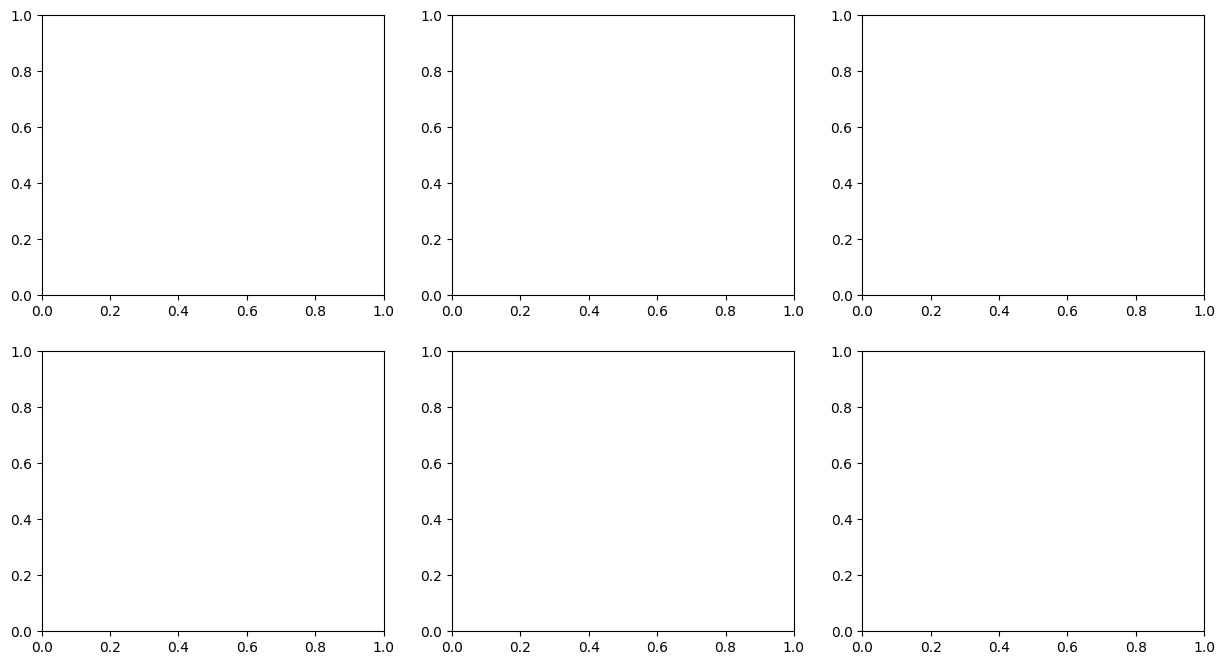

In [81]:
# Extract relevant information
timesteps = np.arange(10,250, 10)

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Plot in the first subplot
rewards = [scalars.value for scalars in event_acc.Scalars('rollout/ep_rew_mean')]
axes[0, 0].plot(timesteps, rewards)
axes[0, 0].set_xlabel('Total Iterations completed')
axes[0, 0].set_ylabel('Average Episode Reward')
axes[0, 0].set_title('Training Progress')

# Plot in the first subplot
rewards = [scalars.value for scalars in event_acc.Scalars('train/entropy_loss')]
axes[0, 1].plot(timesteps, rewards)
axes[0, 1].set_xlabel('Total Iterations completed')
axes[0, 1].set_ylabel('Entropy Loss')
axes[0, 1].set_title('Training Progress')

# Plot in the first subplot
rewards = [scalars.value for scalars in event_acc.Scalars('train/explained_variance')]
axes[0, 2].plot(timesteps, rewards)
axes[0, 2].set_xlabel('Total Iterations completed')
axes[0, 2].set_ylabel('Variance')
axes[0, 2].set_title('Training Progress')

# Plot in the first subplot
rewards = [scalars.value for scalars in event_acc.Scalars('train/loss')]
axes[1, 0].plot(timesteps, rewards)
axes[1, 0].set_xlabel('Total Iterations completed')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training Progress')

# Plot in the first subplot
rewards = [scalars.value for scalars in event_acc.Scalars('train/policy_gradient_loss')]
axes[1, 1].plot(timesteps, rewards)
axes[1, 1].set_xlabel('Total Iterations completed')
axes[1, 1].set_ylabel('Policy Gradient Loss')
axes[1, 1].set_title('Training Progress')

# Plot in the first subplot
rewards = [scalars.value for scalars in event_acc.Scalars('train/value_loss')]
axes[1, 2].plot(timesteps, rewards)
axes[1, 2].set_xlabel('Total Iterations completed')
axes[1, 2].set_ylabel('Value Loss')
axes[1, 2].set_title('Training Progress')

# Adjust layout
plt.tight_layout()
plt.savefig("Graph")
plt.show()

In [132]:
wh = globals()['info']['Peptide after step']

'Not found!'